In [1]:
import jax
import jax.numpy as jnp
import approx_post
import oed_toolbox
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.insert(0, '..')
import plotting_helpers
import computation_helpers

Plot settings:

In [2]:
# Plot theme:
sns.set_theme(style='darkgrid')

Save directory for figs:

In [3]:
fig_save_dir = './figs'
if not os.path.isdir(fig_save_dir):
    os.makedirs(fig_save_dir)

# Create Model + Data

In [4]:
def create_data(model, true_theta, noise_cov, num_samples, ndim, prngkey):
    mean = model(true_theta, 0)
    samples = jax.random.multivariate_normal(key=prngkey, mean=mean, cov=noise_cov, shape=(num_samples,))
    return samples.reshape(num_samples, -1)

In [5]:
# First, let's define a model:
ndim = 1
model_func = lambda theta, x: theta**2
model, model_grad = approx_post.models.from_jax(model_func)

In [6]:
# Create artificial data:
prngkey = jax.random.PRNGKey(10)
true_theta = jnp.array([2.5])
noise_cov = jnp.identity(ndim)
num_samples = 1
data = create_data(model_func, true_theta, noise_cov, num_samples, ndim, prngkey)
print(data)

[[4.9054594]]


In [7]:
# Create Gaussian approximate distribution:
approx_dist = approx_post.distributions.approx.Gaussian(ndim)

In [8]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

# Reverse KL Approximation

In [9]:
reverse_approx = approx_post.distributions.approx.Gaussian(ndim)
prngkey = jax.random.PRNGKey(12)
loss = approx_post.losses.ELBO(joint_dist, use_reparameterisation=True)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(reverse_approx, loss, data, prngkey, verbose=True, max_iter=50, num_samples=1000)

Loss = 9.38978385925293, Params = Jaxtainer({'mean': DeviceArray([-0.09999999], dtype=float32), 'log_chol_diag': DeviceArray([0.1], dtype=float32)})
Loss = 9.072261810302734, Params = Jaxtainer({'mean': DeviceArray([-0.19616626], dtype=float32), 'log_chol_diag': DeviceArray([0.19603479], dtype=float32)})
Loss = 8.944906234741211, Params = Jaxtainer({'mean': DeviceArray([-0.29393485], dtype=float32), 'log_chol_diag': DeviceArray([0.2628494], dtype=float32)})
Loss = 9.053630828857422, Params = Jaxtainer({'mean': DeviceArray([-0.37431547], dtype=float32), 'log_chol_diag': DeviceArray([0.26708144], dtype=float32)})
Loss = 9.077866554260254, Params = Jaxtainer({'mean': DeviceArray([-0.41594568], dtype=float32), 'log_chol_diag': DeviceArray([0.23708388], dtype=float32)})
Loss = 8.979948997497559, Params = Jaxtainer({'mean': DeviceArray([-0.4353067], dtype=float32), 'log_chol_diag': DeviceArray([0.19281419], dtype=float32)})
Loss = 8.886902809143066, Params = Jaxtainer({'mean': DeviceArray([-

# Forward KL Approximation

In [10]:
forward_approx = approx_post.distributions.approx.Gaussian(ndim)
prngkey = jax.random.PRNGKey(12)
loss = approx_post.losses.ForwardKL(joint_dist, use_reparameterisation=False)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(forward_approx, loss, data, prngkey, verbose=True, max_iter=50, num_samples=1000)

Loss = 0.003424657043069601, Params = Jaxtainer({'mean': DeviceArray([0.09999511], dtype=float32), 'log_chol_diag': DeviceArray([0.09999973], dtype=float32)})
Loss = 0.00301481899805367, Params = Jaxtainer({'mean': DeviceArray([0.1608822], dtype=float32), 'log_chol_diag': DeviceArray([0.19815028], dtype=float32)})
Loss = 0.002770861377939582, Params = Jaxtainer({'mean': DeviceArray([0.18071854], dtype=float32), 'log_chol_diag': DeviceArray([0.2937233], dtype=float32)})
Loss = 0.002552117919549346, Params = Jaxtainer({'mean': DeviceArray([0.17049895], dtype=float32), 'log_chol_diag': DeviceArray([0.38546976], dtype=float32)})
Loss = 0.002405518898740411, Params = Jaxtainer({'mean': DeviceArray([0.13896486], dtype=float32), 'log_chol_diag': DeviceArray([0.4724738], dtype=float32)})
Loss = 0.0022972463630139828, Params = Jaxtainer({'mean': DeviceArray([0.09242714], dtype=float32), 'log_chol_diag': DeviceArray([0.5538978], dtype=float32)})
Loss = 0.002221341710537672, Params = Jaxtainer({'

# Plots

Create true posterior:

In [11]:
true_posterior = computation_helpers.construct_true_posterior(model_func, noise_cov, prior_mean, prior_cov,
                                                              theta_lims=(-5,5))

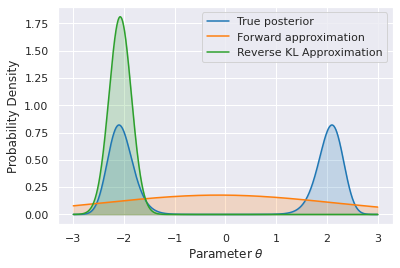

In [12]:
theta_plot = jnp.linspace(-3,3,1000).reshape(-1,1)
pdfs = {'True posterior': true_posterior(theta_plot, data, 0),
        'Forward approximation': jnp.exp(forward_approx.logpdf(theta_plot)),
        'Reverse KL Approximation': jnp.exp(reverse_approx.logpdf(theta_plot))}
plotting_helpers.plot_distributions(pdfs, theta_plot, 'Parameter $\\theta$')
plt.savefig(os.path.join(fig_save_dir, 'nonamortised_vi.pdf'), bbox_inches='tight')